# Summary

In [1]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

sns.set_context("paper", font_scale=1.4)
sns.set_style("darkgrid")

### Load experiments results

In [2]:
lr_res = joblib.load(os.path.join('Experiment_results', 'LogisticRegression', 'lr_res.pth'))
dt_res = joblib.load(os.path.join('Experiment_results', 'DecisionTree', 'dt_res.pth'))
rf_res = joblib.load(os.path.join('Experiment_results', 'RandomForest', 'rf_res.pth'))
lgb_res = joblib.load(os.path.join('Experiment_results', 'LightGBM', 'lgb_res.pth'))

lr_experiment = joblib.load(os.path.join('Experiment_results', 'LogisticRegression', 'lr_experiment.pth'))
dt_experiment = joblib.load(os.path.join('Experiment_results', 'DecisionTree', 'dt_experiment.pth'))
rf_experiment = joblib.load(os.path.join('Experiment_results', 'RandomForest', 'rf_experiment.pth'))
lgb_experiment = joblib.load(os.path.join('Experiment_results', 'LightGBM', 'lgb_experiment.pth'))

### Summary table

In [9]:
np.round(pd.concat([
    pd.Series(['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM'], name='Model'),
    pd.Series([lr_res['dev_gini'][0], dt_res['dev_gini'][0], rf_res['dev_gini'][0], lgb_res['dev_gini'][0]], name='Mean dev GINI'),
    pd.Series([lr_res['dev_gini'][1], dt_res['dev_gini'][1], rf_res['dev_gini'][1], lgb_res['dev_gini'][1]], name='Std dev GINI'),
    pd.Series([lr_res['test_gini'], dt_res['test_gini'], rf_res['test_gini'], lgb_res['test_gini']], name='Test GINI'),
    pd.Series([lr_res['ap'], dt_res['ap'], rf_res['ap'], lgb_res['ap']], name='Test AP'),
    ], axis=1
), 3)

,Model,Mean dev GINI,Std dev GINI,Test GINI,Test AP
0,LogisticRegression,0.476,0.009,0.475,0.504
1,DecisionTree,0.513,0.010,0.523,0.526
2,RandomForest,0.560,0.009,0.571,0.567
3,LightGBM,0.561,0.009,0.572,0.565


### Boxplot

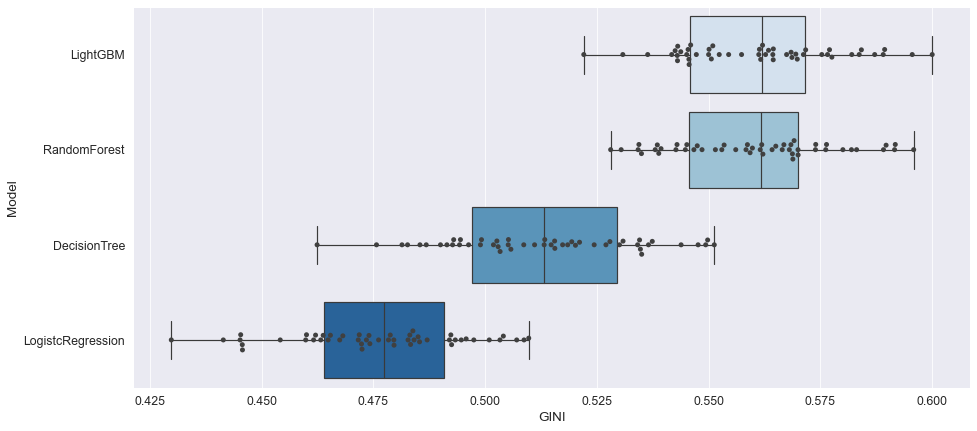

In [4]:
lr = pd.DataFrame(pd.Series(lr_res['val_scores'], name='GINI'))
lr['Model'] = 'LogistcRegression'

dt = pd.DataFrame(pd.Series(dt_res['val_scores'], name='GINI'))
dt['Model'] = 'DecisionTree'

rf = pd.DataFrame(pd.Series(rf_res['val_scores'], name='GINI'))
rf['Model'] = 'RandomForest'

lgb = pd.DataFrame(pd.Series(lgb_res['val_scores'], name='GINI'))
lgb['Model'] = 'LightGBM'

val_scores_comp = pd.concat([dt, lr, rf, lgb], axis=0).sort_values('GINI', ascending=False)

fig, axs = plt.subplots(1, 1, figsize=(15,7))
sns.boxplot(x='GINI', y='Model', data=val_scores_comp, palette="Blues")
sns.swarmplot(x='GINI', y='Model', data=val_scores_comp, color=".25")

plt.savefig(os.path.join("Experiment_results", "Summary", "val_gini.png"), facecolor="w")

### ROC & PR

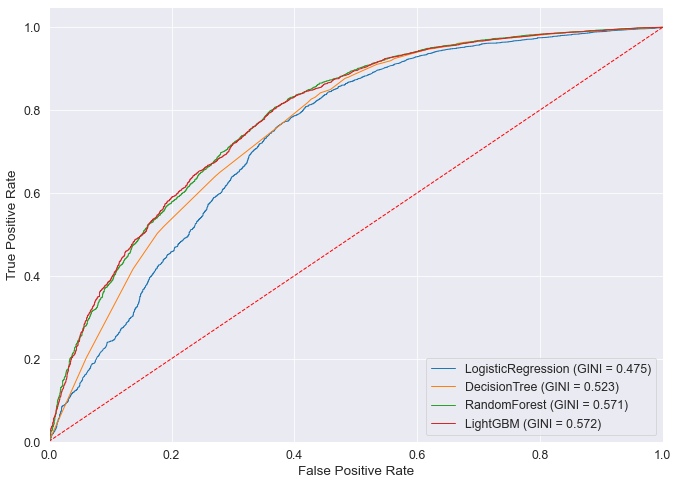

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(11,8))

fpr, tpr = lr_res['fpr_tpr'][0], lr_res['fpr_tpr'][1]
ax.plot(fpr, tpr, lw=1, label='LogisticRegression (GINI = %0.3f)' % (lr_res['test_gini']))
fpr, tpr = dt_res['fpr_tpr'][0], dt_res['fpr_tpr'][1]
ax.plot(fpr, tpr, lw=1, label='DecisionTree (GINI = %0.3f)' % (dt_res['test_gini']))
fpr, tpr = rf_res['fpr_tpr'][0], rf_res['fpr_tpr'][1]
ax.plot(fpr, tpr, lw=1, label='RandomForest (GINI = %0.3f)' % (rf_res['test_gini']))
fpr, tpr = lgb_res['fpr_tpr'][0], lgb_res['fpr_tpr'][1]
ax.plot(fpr, tpr, lw=1, label='LightGBM (GINI = %0.3f)' % (lgb_res['test_gini']))
ax.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")

plt.savefig(os.path.join("Experiment_results", "Summary", "roc.png"), facecolor="w")

TypeError: 'AxesSubplot' object is not subscriptable

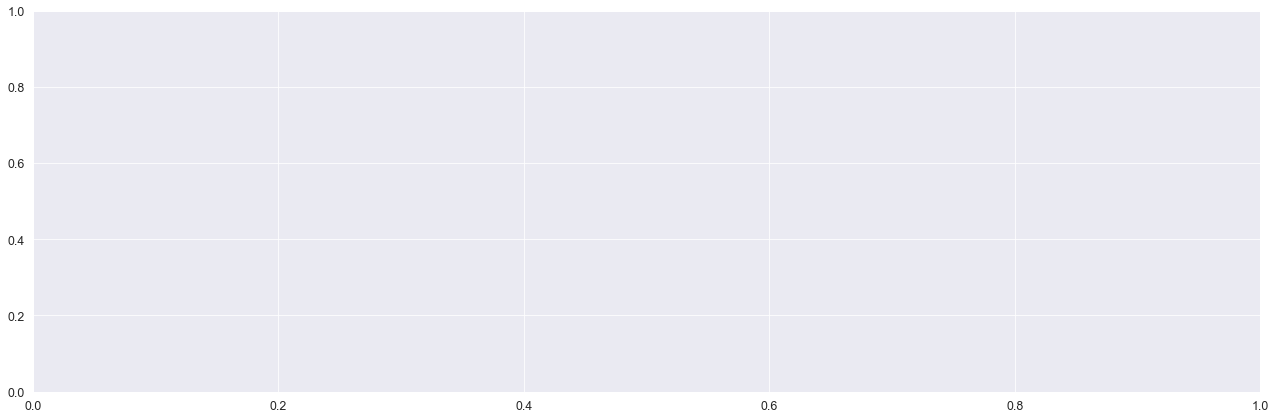

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(11,8))

precision, recall = lr_res['pr_rec'][0], lr_res['pr_rec'][1]
ax.plot(recall, precision, lw=1, label='LogisticRegression (AP = %0.3f)' % (lr_res['ap']))
precision, recall = dt_res['pr_rec'][0], dt_res['pr_rec'][1]
ax.plot(recall, precision, lw=1, label='DecisionTree (AP = %0.3f)' % (dt_res['ap']))
precision, recall = rf_res['pr_rec'][0], rf_res['pr_rec'][1]
ax.plot(recall, precision, lw=1, label='RandomForest (AP = %0.3f)' % (rf_res['ap']))
precision, recall = lgb_res['pr_rec'][0], lgb_res['pr_rec'][1]
ax.plot(recall, precision, lw=1, label='LightGBM (AP = %0.3f)' % (lgb_res['ap']))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")

plt.savefig(os.path.join("Experiment_results", "Summary", "pr.png"), facecolor="w")

### Performance vs sample size

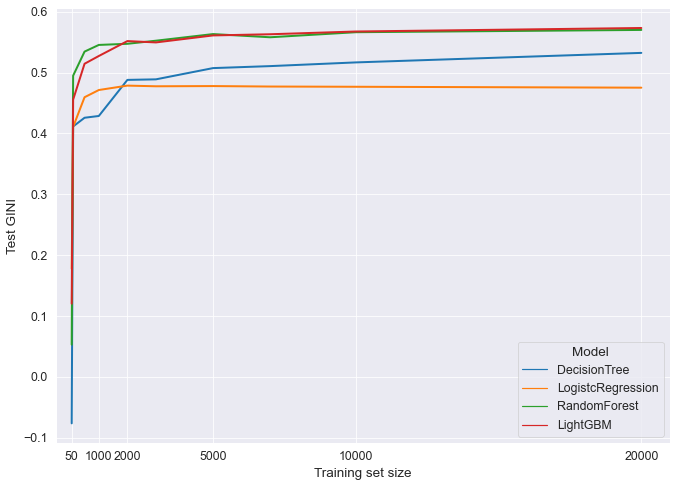

In [6]:
lr = lr_experiment[['Training set size', 'Test GINI']]
lr['Model'] = 'LogistcRegression'

dt = dt_experiment[['Training set size', 'Test GINI']]
dt['Model'] = 'DecisionTree'

rf = rf_experiment[['Training set size', 'Test GINI']]
rf['Model'] = 'RandomForest'

lgb = lgb_experiment[['Training set size', 'Test GINI']]
lgb['Model'] = 'LightGBM'

experiment_comp = pd.concat([dt, lr, rf, lgb], axis=0)

fig, ax = plt.subplots(figsize=(11,8))
sns.lineplot(data=experiment_comp, x='Training set size', y='Test GINI', hue='Model', lw=2)
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

plt.savefig(os.path.join("Experiment_results", "Summary", "set_size.png"), facecolor="w")

### Hyperparameters optimization time

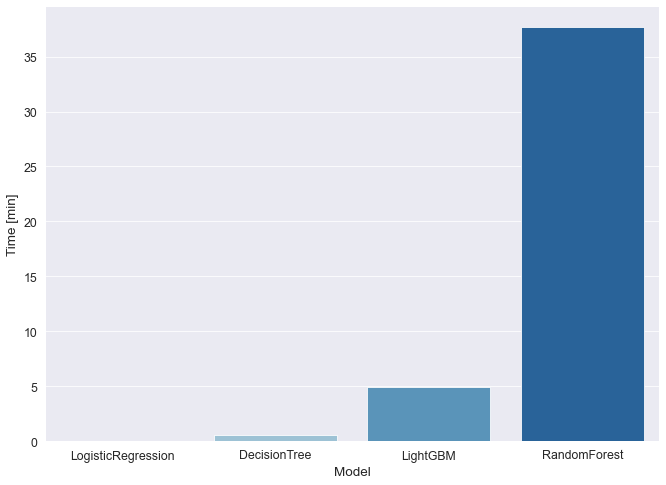

In [7]:
times = pd.concat([
    pd.Series(["LogisticRegression", "DecisionTree", "RandomForest", "LightGBM"], name="Model"),
    pd.Series([lr_res['optimization_time'], dt_res['optimization_time']/60, rf_res['optimization_time']/60, lgb_res['optimization_time']/60], name="Time [min]"),
], axis=1).sort_values('Time [min]')

fig, axs = plt.subplots(1, 1, figsize=[11,8])
sns.barplot(x='Model', y='Time [min]', data=times, palette='Blues')

plt.savefig(os.path.join("Experiment_results", "Summary", "times.png"), facecolor="w")

In [8]:
pd.concat([
    pd.Series(['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM'], name='Model'),
    pd.Series([lr_res['optimization_time'], dt_res['optimization_time'], rf_res['optimization_time'], lgb_res['optimization_time']], name='Time'),
    ], axis=1
)

,Model,Time
0,LogisticRegression,0.000000
1,DecisionTree,34.641706
2,RandomForest,2261.977162
3,LightGBM,295.459778
